In [34]:
import pandas as pd
import sklearn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

Dataframe from MDA_merge_data.ipynb is loaded, datetime column is dropped in order to run model.

In [2]:
df = pd.read_csv("C:\\Users\Arthur\hello\\final_df.csv", delimiter=";")
df_fil = df[df['object_id']==255443]
df_fil = df_fil.sort_values(by='result_timestamp')
df_fil['result_timestamp'] = pd.to_datetime(df_fil['result_timestamp'],format='%Y-%m-%d %H:%M:%S')
df_noisedelay = df_fil[['result_timestamp','laeq']]
df_noisedelay['result_timestamp'] = df_noisedelay['result_timestamp']+pd.DateOffset(days=1)
df_noisedelay['laeq_delayed'] = df_noisedelay['laeq']
df_noisedelay = df_noisedelay.drop('laeq', axis=1)
df_fil = pd.merge(df_fil,df_noisedelay, on='result_timestamp',validate='1:1')
df_fil_nd = df_fil.drop(['object_id','result_timestamp','date','time','day_time','day_hour','LC_TEMP_QCL1','LC_TEMP_QCL2','LC_TEMP_QCL3'], axis=1)
df_fil

C:\Users\Arthur\AppData\Local\Temp\ipykernel_16556\3924323217.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['result_timestamp'] = df_noisedelay['result_timestamp']+pd.DateOffset(days=1)
C:\Users\Arthur\AppData\Local\Temp\ipykernel_16556\3924323217.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['laeq_delayed'] = df_noisedelay['laeq']


,object_id,result_timestamp,laeq,date,time,hour,weekday,month,weekend,day_time,...,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,LC_TEMP_QCL1,LC_TEMP_QCL2,LC_TEMP_QCL3,laeq_delayed
0,255443,2022-01-02 00:00:00,41.985767,2022-01-02,00:00:00,0,Sunday,1,True,Sunday 00:00:00,...,0.0,0.0,-12.0,0.10,0.0,12.28,12.28,12.223,12.29677,54.790667
1,255443,2022-01-02 00:10:00,40.954667,2022-01-02,00:10:00,0,Sunday,1,True,Sunday 00:10:00,...,0.0,0.0,-23.0,0.09,0.0,12.33,12.33,12.273,12.35607,48.605833
2,255443,2022-01-02 00:20:00,37.623667,2022-01-02,00:20:00,0,Sunday,1,True,Sunday 00:20:00,...,0.0,0.0,-7.0,0.05,0.0,12.39,12.39,12.333,12.34995,54.277833
3,255443,2022-01-02 00:30:00,36.445333,2022-01-02,00:30:00,0,Sunday,1,True,Sunday 00:30:00,...,0.0,0.0,-32.0,0.17,0.0,12.42,12.42,12.363,12.33459,50.025333
4,255443,2022-01-02 00:40:00,38.298000,2022-01-02,00:40:00,0,Sunday,1,True,Sunday 00:40:00,...,0.0,0.0,29.0,0.03,0.0,12.51,12.51,12.453,12.35354,48.907333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52243,255443,2022-12-31 23:10:00,52.203333,2022-12-31,23:10:00,23,Saturday,12,True,Saturday 23:10:00,...,0.0,0.0,-9.0,0.40,0.0,16.61,16.61,16.553,16.52797,50.290833
52244,255443,2022-12-31 23:20:00,54.622833,2022-12-31,23:20:00,23,Saturday,12,True,Saturday 23:20:00,...,0.0,0.0,5.0,0.29,0.0,16.61,16.61,16.553,16.57995,49.906667
52245,255443,2022-12-31 23:30:00,56.135667,2022-12-31,23:30:00,23,Saturday,12,True,Saturday 23:30:00,...,0.0,0.0,-17.0,0.15,0.0,16.51,16.51,16.453,16.44846,49.204667
52246,255443,2022-12-31 23:40:00,59.380333,2022-12-31,23:40:00,23,Saturday,12,True,Saturday 23:40:00,...,0.0,0.0,-31.0,0.29,0.0,16.49,16.49,16.433,16.46641,49.829333


In [3]:
df_fil_nd = df_fil_nd[df_fil_nd.isna()['LC_HUMIDITY']==False]
df_fil_nd['weekday'] = df_fil_nd['weekday'].replace(to_replace='Monday', value=0)
df_fil_nd['weekday'] = df_fil_nd['weekday'].replace(to_replace='Tuesday', value=1)
df_fil_nd['weekday'] = df_fil_nd['weekday'].replace(to_replace='Wednesday', value=2)
df_fil_nd['weekday'] = df_fil_nd['weekday'].replace(to_replace='Thursday', value=3)
df_fil_nd['weekday'] = df_fil_nd['weekday'].replace(to_replace='Friday', value=4)
df_fil_nd['weekday'] = df_fil_nd['weekday'].replace(to_replace='Saturday', value=5)
df_fil_nd['weekday'] = df_fil_nd['weekday'].replace(to_replace='Sunday', value=6)

df_fil_nd

,laeq,hour,weekday,month,weekend,holiday,exam_period,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,laeq_delayed
0,41.985767,0,6,1,True,True,False,80.0,9.00,37.0,0.0,0.0,0.0,-12.0,0.10,0.0,12.28,54.790667
1,40.954667,0,6,1,True,True,False,80.0,9.05,38.0,0.0,0.0,0.0,-23.0,0.09,0.0,12.33,48.605833
2,37.623667,0,6,1,True,True,False,80.0,9.11,37.0,0.0,0.0,0.0,-7.0,0.05,0.0,12.39,54.277833
3,36.445333,0,6,1,True,True,False,79.0,8.99,38.0,0.0,0.0,0.0,-32.0,0.17,0.0,12.42,50.025333
4,38.298000,0,6,1,True,True,False,79.0,9.01,37.0,0.0,0.0,0.0,29.0,0.03,0.0,12.51,48.907333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52243,52.203333,23,5,12,True,True,False,52.0,6.79,38.0,0.0,0.0,0.0,-9.0,0.40,0.0,16.61,50.290833
52244,54.622833,23,5,12,True,True,False,52.0,6.74,38.0,0.0,0.0,0.0,5.0,0.29,0.0,16.61,49.906667
52245,56.135667,23,5,12,True,True,False,52.0,6.62,37.0,0.0,0.0,0.0,-17.0,0.15,0.0,16.51,49.204667
52246,59.380333,23,5,12,True,True,False,52.0,6.60,38.0,0.0,0.0,0.0,-31.0,0.29,0.0,16.49,49.829333


The target dataset (y) and predictor dataset (X) are created. For y, noise is converted to relative noise (proportion of max value)

In [4]:
y = df_fil_nd["laeq"]
X = df_fil_nd.drop(["laeq","laeq_delayed"], axis="columns")

In [5]:
#create time-sensitive split for cross-validation
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=4320,
    max_train_size=10000,
    test_size=1000,
)

In [6]:
#inspect splits
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
X.iloc[test_0]
X.iloc[train_0]

,hour,weekday,month,weekend,holiday,exam_period,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
32925,19,4,8,False,True,False,93.0,19.19,32.0,0.0,0.0,0.003,0.0,0.0,0.0,20.28
32926,19,4,8,False,True,False,93.0,19.11,32.0,0.0,0.0,0.003,0.0,0.0,0.0,20.22
32927,19,4,8,False,True,False,93.0,19.10,31.0,0.0,0.0,0.003,0.0,0.0,0.0,20.22
32928,20,4,8,False,True,False,93.0,19.08,32.0,0.0,0.0,0.003,0.0,0.0,0.0,20.22
32929,20,4,8,False,True,False,93.0,19.19,31.0,0.0,0.0,0.003,0.0,0.0,0.0,20.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42923,5,4,10,False,False,False,81.0,13.38,38.0,0.0,0.0,0.000,0.0,0.0,0.0,16.72
42924,6,4,10,False,False,False,81.0,13.47,37.0,0.0,0.0,0.000,0.0,0.0,0.0,16.76
42925,6,4,10,False,False,False,81.0,13.39,38.0,0.0,0.0,0.000,0.0,0.0,0.0,16.72
42926,6,4,10,False,False,False,82.0,13.60,37.0,0.0,0.0,0.000,0.0,0.0,0.0,16.68


In [7]:
train_4, test_4 = all_splits[4]
X.iloc[test_4]
X.iloc[train_4]

,hour,weekday,month,weekend,holiday,exam_period,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
36925,14,4,9,False,True,False,86.0,10.93,32.0,64.0,0.0,0.004,35.0,0.19,132.0,13.15
36926,14,4,9,False,True,False,86.0,10.94,31.0,55.0,0.0,0.004,-106.0,0.03,86.0,13.25
36927,14,4,9,False,True,False,86.0,10.82,32.0,106.0,0.0,0.004,-42.0,0.06,97.0,13.18
36928,14,4,9,False,True,False,84.0,10.52,32.0,127.0,0.0,0.004,15.0,0.21,101.0,13.10
36929,14,4,9,False,True,False,81.0,9.88,31.0,77.0,0.0,0.004,9.0,0.28,91.0,13.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46923,0,4,11,False,False,False,82.0,8.54,38.0,0.0,0.0,0.000,96.0,0.11,0.0,11.55
46924,0,4,11,False,False,False,82.0,8.61,37.0,0.0,0.0,0.000,81.0,0.25,0.0,11.61
46925,0,4,11,False,False,False,84.0,8.86,38.0,0.0,0.0,0.000,34.0,0.06,0.0,11.58
46926,1,4,11,False,False,False,84.0,8.87,37.0,0.0,0.0,0.000,-129.0,0.02,0.0,11.48


In [22]:
# grid search for hyperparameter tuning

param_grid = {
    'learning_rate': (0.04,0.05,0.06),
    'n_estimators': (70,80,90),
    'max_depth' : (4,5,6)}
model = xgb.XGBRegressor()
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=ts_cv)
model_grid_search.fit(X, y)


GridSearchCV(cv=TimeSeriesSplit(gap=4320, max_train_size=10000, n_splits=5, test_size=1000),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=2,
             param_grid={'learning_rate': (0.04, 0.05, 0.06),
                         'max_depth': (4, 5, 6), 'n_estimators': (70, 80, 90)})

In [23]:
accuracy = model_grid_search.score(X, y)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.72


In [24]:
model_grid_search.predict(X.iloc[0:5])

array([40.78403 , 40.78403 , 40.462406, 40.373535, 40.462406],
      dtype=float32)

In [25]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'learning_rate': 0.04, 'max_depth': 5, 'n_estimators': 80}


In [26]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.557793,0.020812,0.008481,0.001785,0.04,5,80,"{'learning_rate': 0.04, 'max_depth': 5, 'n_est...",0.805561,0.737418,0.791473,0.777810,0.733143,0.769081,0.028991,1
5,0.699482,0.025031,0.008478,0.001608,0.04,5,90,"{'learning_rate': 0.04, 'max_depth': 5, 'n_est...",0.821268,0.774538,0.793973,0.764575,0.684882,0.767847,0.045771,2
12,0.622198,0.008408,0.009277,0.000747,0.05,5,70,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",0.816241,0.761350,0.797143,0.770954,0.681763,0.765490,0.046119,3
9,0.593983,0.105019,0.009774,0.002393,0.05,4,70,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",0.823534,0.731936,0.797270,0.767873,0.665122,0.757147,0.055202,4
1,0.479858,0.036463,0.007180,0.001164,0.04,4,80,"{'learning_rate': 0.04, 'max_depth': 4, 'n_est...",0.813613,0.707776,0.796249,0.771521,0.692669,0.756366,0.047991,5


In [27]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [28]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,param_learning_rate,param_n_estimators,param_max_depth,mean_test_score,std_test_score,rank_test_score
4,0.04,80,5,0.769081,0.028991,1
5,0.04,90,5,0.767847,0.045771,2
12,0.05,70,5,0.765490,0.046119,3
9,0.05,70,4,0.757147,0.055202,4
1,0.04,80,4,0.756366,0.047991,5
2,0.04,90,4,0.752964,0.058823,6
13,0.05,80,5,0.751742,0.061973,7
8,0.04,90,6,0.745181,0.044069,8
15,0.05,70,6,0.744955,0.036341,9
7,0.04,80,6,0.743882,0.046307,10


In [29]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["param_max_depth"],
    columns=["param_n_estimators"])

pivoted_cv_results

param_n_estimators,70,80,90
param_max_depth,,,
4,0.736825,0.737806,0.725882
5,0.745174,0.750212,0.738633
6,0.721942,0.727417,0.718269


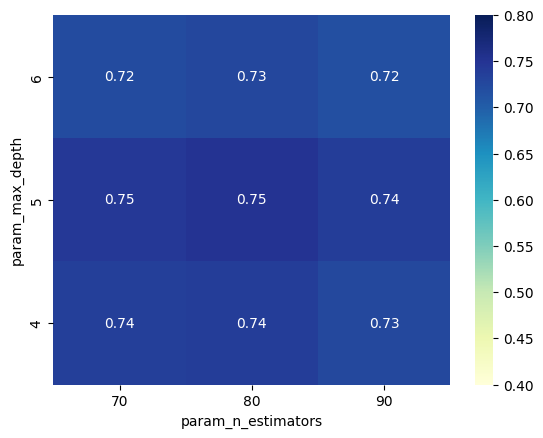

In [30]:
import seaborn as sns

ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.4,
                 vmax=0.8)
ax.invert_yaxis()

In [45]:
#run XGBoost model
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

gbrt_pipeline = xgb.XGBRegressor(learning_rate=0.05,n_estimators=80,max_depth=5)

evaluate(gbrt_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     2.437 +/- 0.305
Root Mean Squared Error: 3.164 +/- 0.384


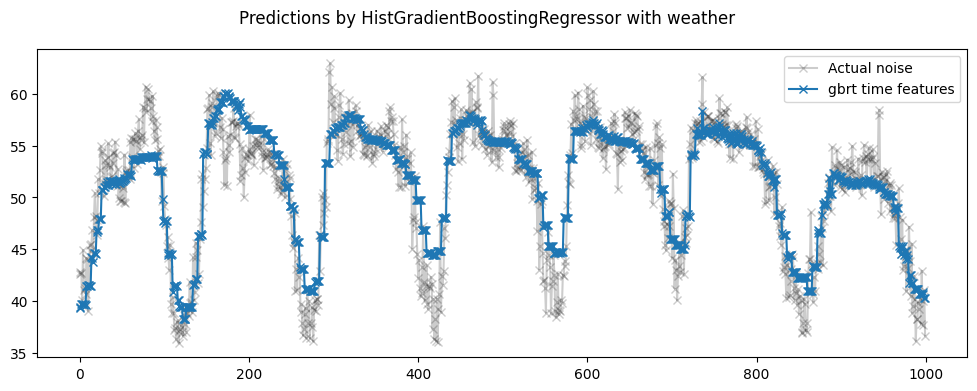

In [46]:
#Qualitative analysis of the impact of features on linear model predictions
gbrt_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
gbrt_predictions = gbrt_pipeline.predict(X.iloc[test_0])

last_hours = slice(-1000, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by HistGradientBoostingRegressor with weather")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual noise",
    color="black",
)
ax.plot(gbrt_predictions[last_hours], "x-", label="gbrt time features")
_ = ax.legend()


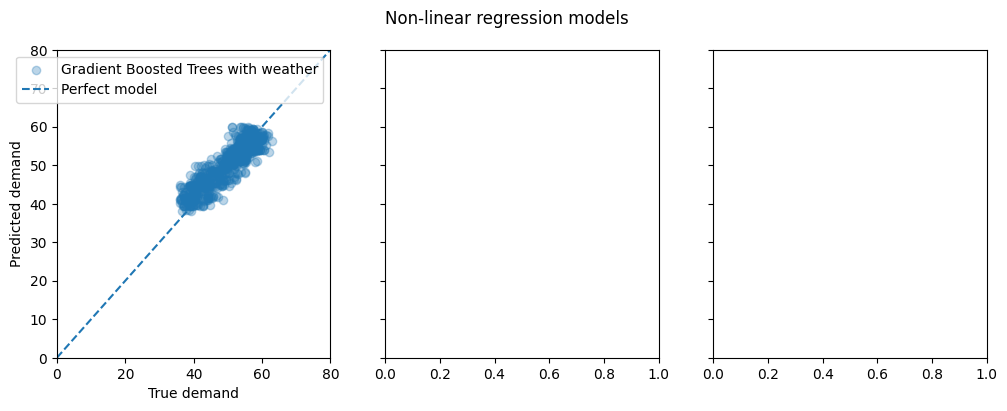

In [47]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    gbrt_predictions,
]
labels = [
    "Gradient Boosted Trees with weather",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.iloc[test_0].values, pred, alpha=0.3, label=label)
    ax.plot([0, 80], [0, 80], "--", label="Perfect model")
    ax.set(
        xlim=(0, 80),
        ylim=(0, 80),
        xlabel="True demand",
        ylabel="Predicted demand",
    )
    ax.legend()

plt.show()

In [51]:
#now do the same but look at variables separately: 
# the feature importance should be lower, because dropping a variable form the model 
# will not result in a large decrease of information gain, etc if the other correlated variables take over the task of explaining the model 
#example: you can see that weekend is not as important anymore, because day takes over if weekend is in the model
features=['hour','weekday','month','weekend','holiday','exam_period','LC_HUMIDITY','LC_DWPTEMP','LC_n',
          'LC_RAD','LC_RAININ','LC_DAILYRAIN','LC_WINDDIR','LC_WINDSPEED','LC_RAD60','LC_TEMP_QCL0']
imp = importances(gbrt_pipeline, X, y, features=features) # permutation
#should be on fitted model. I used the X and y but usualy you would need to use the validation set
viz = plot_importances(imp)
viz.view()

NameError: name 'importances' is not defined